In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy as sc
from scipy.optimize import curve_fit # For fitting redshift distribution
from scipy.optimize import newton    # For finding roots to nonlinear equation
import scipy.integrate as integrate  # For integration

from PIL import Image
import pylab                         # For generating contours of image

from astropy.coordinates import Distance    # For changing from redshift to distance
from astropy.cosmology import WMAP7, WMAP9  # For changing from redshift to distance
from astropy import units as u

# For auxiliary functions
import time
import sys

$$AU = 149.6 \text{ million km}$$

$$\text{parsec} = 3.26 \text{ light years } = 30.9 \text{ trillion km}$$

$$H_0 = 70 km/s/Mpc$$

$$M_\odot = 2\times 10^{30}kg$$

$$r_\odot = 7\times 10^{8}km$$

In [92]:
# Defining constants
c = 3e+8             # speed of light in m/s
AU = 1.5e+11       # astronomical unit = 149.6 million km
G = 6.67e-11      # Gravitational constant in Nm^2 kg^-2 == m^3 kg^-1 s^-2
pc = 3e+16       # parsec = 3.26 light years = 206,000 AU = 30.9 trillion km
Gpc = 1e9*pc
H_0 = 70e3           # Cosmological constant in m/(s Mpc)

# Defining radius and mass parameters of the system
M_sun = 2e+30    # in kg
M_earth = 6e+24 / M_sun # in solar masses
r_sun = 7e+8    # 696,340 km
r_earth = 6.4e+6/AU    # 6371 km, variable in AU

rho_crit_0 = 9.21e-27 / M_sun    # critical density in solar masses per m^3
Omega_DM = 0.26

Lagrange Point under reduced mass constraint $$R_{L_2} = R\left(\frac{M_2}{3M_1}\right)^{1/3}$$

In [3]:
# Function to calculate location of L2, under reduced mass constraint
# R = distance between two masses M1, M2
# M1 = Mass of the larger object
# M2 = Mass of the smaller object
# https://en.wikipedia.org/wiki/Lagrange_point#L2
# Output: Langrange point distance in AU
def L2_point(R, M1, M2):
    return (R * (M2/(3*M1))**(1/3))

### Redshift vs GRB Distribution

In [4]:
redshift = np.genfromtxt('redshift.csv',delimiter=',')

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


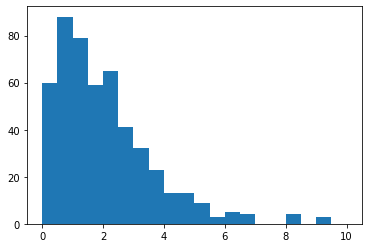

In [5]:
fig,ax = plt.subplots(1,1)
bins = np.linspace(0, 10, 21)
print(bins)
data_entries, bins = np.histogram(redshift, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
ax.hist(redshift, bins = bins)
plt.show()

Poisson distribution: $A.x.e^{-\alpha x} \equiv 495xe^{-1.025x}$

In [6]:
def fit_function(x, A, alpha):
    return (A * x * np.exp(-x*alpha))

popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[240,1.3])
print(popt)

[247.52234509   1.02585546]


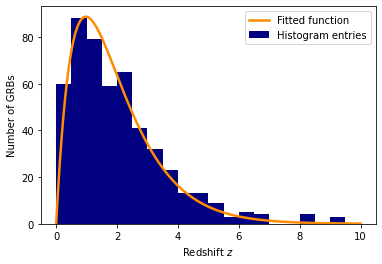

In [7]:
xspace = np.linspace(0, 10, 100000)
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
#plt.title(r'Exponential decay with gaussian peak')
plt.legend(loc='best')
#plt.savefig('fitted_distribution.png')
plt.show()

Refer [scipy tutorial](https://riptutorial.com/scipy/example/31081/fitting-a-function-to-data-from-a-histogram) for further information

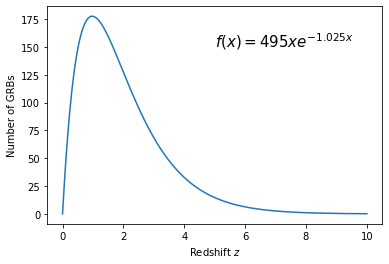

In [8]:
popt2 = np.array([247.52234509, 1.02585546])
popt2[0] /= 0.5
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
plt.plot(xspace, fit_function(xspace,*popt2))
ax.text(5, 150, r'$f(x)=495x e^{-1.025x}$', fontsize=15)
#plt.savefig('distribution accounting for bin size.png')
plt.show()

In [9]:
Num_GRBs = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) # Number of GRBs in +/- 0.05 for a given redshift
GRB_distribution = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) / integrate.quad(Num_GRBs, 0, 10)[0] # GRB progenitor distribution as a function of redshift
Pr_GRB_zS = lambda z_S: integrate.quad(GRB_distribution, z_S - 0.25, z_S + 0.25) # Probability of selected GRB having z_S +/- 0.25 redshift

In [10]:
GRB_dbt_bin_size = 20
Pr_GRB_zS_numeric = np.zeros(GRB_dbt_bin_size)
for i in range(GRB_dbt_bin_size):
    Pr_GRB_zS_numeric[i] = Pr_GRB_zS(10/GRB_dbt_bin_size*i + 10/GRB_dbt_bin_size/2)[0]

In [11]:
Pr_GRB_zS_numeric

array([0.09418673, 0.17967312, 0.18139002, 0.15279999, 0.1179485 ,
       0.08646377, 0.06125533, 0.04235567, 0.02876067, 0.01925626,
       0.01274859, 0.00836301, 0.0054443 , 0.00352139, 0.00226507,
       0.00144999, 0.00092433, 0.00058706, 0.00037163, 0.00023457])

In [12]:
# Block to randomly sample points from GRB progenitor distribution
num_GRB_samples = 1000
l = []
for i in range(GRB_dbt_bin_size):
    for j in range(int(Pr_GRB_zS_numeric[i]*10000)): # 10000 multiplier covers 99.88% of the population space, 1000 -> 99.0%, 100000 -> 99.99%
        l.append(np.random.rand()/2 + i*10/GRB_dbt_bin_size)

In [13]:
GRB_list_redshift = np.array(l)
np.random.shuffle(GRB_list_redshift)

In [14]:
np.size(GRB_list_redshift)

9988

In [15]:
sim_GRB_list_redshift = np.zeros(num_GRB_samples)
size_GRB_list_redshift = np.shape(GRB_list_redshift)[0]
for i in range(num_GRB_samples):
    sim_GRB_list_redshift[i] = GRB_list_redshift[np.random.randint(size_GRB_list_redshift)]

In [16]:
np.min(sim_GRB_list_redshift),np.max(sim_GRB_list_redshift)

(0.004870605836128694, 9.95127764668047)

### Source Star Radius vs GRB Distribution

In [17]:
source_star = np.genfromtxt('source_star.csv',delimiter=',')

[-2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2]


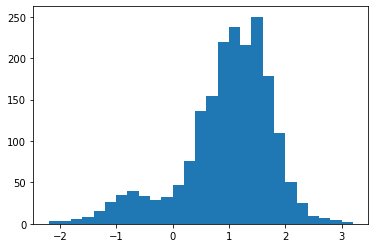

In [18]:
fig,ax = plt.subplots(1,1)
bins = np.linspace(-2.2, 3.2, 28)
print(bins)
data_entries, bins = np.histogram(source_star, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
ax.hist(source_star, bins = bins)
plt.show()

Double Gaussian Distribution: $c_1.e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2}} + c_2.e^{-\frac{(x-\mu_2)^2}{2\sigma_2^2}}$

In [19]:
def fit_function(x, c1, mu1, sigma1, c2, mu2, sigma2):
    return (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))

popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[50,-1,1,250,1,2])
print(popt)

[ 34.34949502  -0.67785818  -0.55209415 248.51853339   1.20256234
   0.55588398]


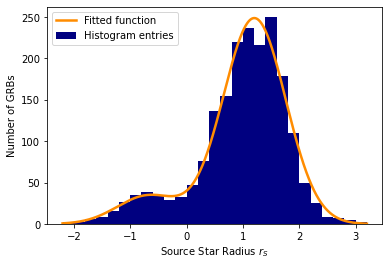

In [20]:
xspace = np.linspace(-2.2, 3.2, 100000)
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.xlabel(r'Source Star Radius $r_S$')
plt.ylabel(r'Number of GRBs')
#plt.title(r'Exponential decay with gaussian peak')
plt.legend(loc='best')
#plt.savefig('fitted_distribution.png')
plt.show()

In [21]:
source_star_2 = source_star
np.random.shuffle(source_star_2)
sim_GRB_list_ss = np.zeros(num_GRB_samples)
size_GRB_list_ss = np.shape(source_star)[0]
for i in range(num_GRB_samples):
    sim_GRB_list_ss[i] = source_star_2[np.random.randint(size_GRB_list_ss)] - 0.1 + 0.2*np.random.rand()

In [22]:
np.min(sim_GRB_list_ss),np.max(sim_GRB_list_ss)

(-2.0624777748971135, 2.9717032267345527)

Einstein Angle $$\theta_E = \sqrt{\frac{4GM}{c^2}\frac{1}{D}} = \sqrt{\frac{4GM}{c^2}\frac{D_{LS}}{D_L D_S}}$$

Einstein Radius $$r_E = \theta_e D_L$$

In [23]:
# Function to calculate Einstein angle of a lensing system
# M = mass of the lens
# D = Effective lensing distance
# Output: Einstein angle in radians
def Einstein_angle(M, D):
    return np.sqrt((4*G*(M*M_sun))/(c**2 * (D*Gpc)))

In [24]:
num_samples = num_GRB_samples

# Defining lensing system parameters (lengths)
DS = WMAP9.comoving_distance(sim_GRB_list_redshift).value/1e3    # Distance between source and observer in Gpc
r_S = sim_GRB_list_ss

Comoving Distance $$\int_0^z \frac{cdz}{H(z)}$$
where $$H(z) = \sqrt{(1+z)^3\Omega_m + (1+z)^4\Omega_r + \Omega_\Lambda}$$

[Source](https://docs.astropy.org/en/stable/cosmology/index.html)

In [25]:
Hofz_inv = lambda z: 1/(H_0*np.sqrt(0.69 + (1+z)**3*0.31))
dcomoving = c*integrate.quad(Hofz_inv, 0, 2)[0]/1e3
print(dcomoving, WMAP9.comoving_distance(2).value/1e3)    # In Gpc

5.13967702165249 5.291730374382688


(array([269., 328., 206., 117.,  40.,  25.,  12.,   1.,   1.,   1.]),
 array([4.87060584e-03, 9.99511310e-01, 1.99415201e+00, 2.98879272e+00,
        3.98343342e+00, 4.97807413e+00, 5.97271483e+00, 6.96735553e+00,
        7.96199624e+00, 8.95663694e+00, 9.95127765e+00]),
 <BarContainer object of 10 artists>)

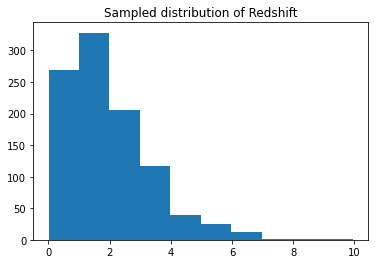

In [28]:
plt.title('Sampled distribution of Redshift')
plt.hist(sim_GRB_list_redshift)

(array([ 33.,  45., 117., 159., 153., 166., 176., 102.,  45.,   4.]),
 array([0.02104213, 0.98653441, 1.95202668, 2.91751896, 3.88301124,
        4.84850352, 5.8139958 , 6.77948808, 7.74498035, 8.71047263,
        9.67596491]),
 <BarContainer object of 10 artists>)

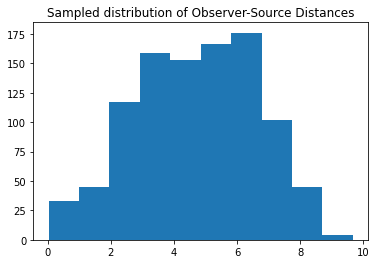

In [26]:
plt.title('Sampled distribution of Observer-Source Distances')
plt.hist(DS)

(array([  7.,  26.,  45.,  44.,  82., 211., 293., 223.,  58.,  11.]),
 array([-2.06247777, -1.55905967, -1.05564157, -0.55222347, -0.04880537,
         0.45461273,  0.95803083,  1.46144893,  1.96486703,  2.46828513,
         2.97170323]),
 <BarContainer object of 10 artists>)

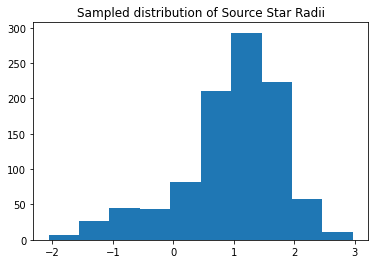

In [27]:
plt.title('Sampled distribution of Source Star Radii')
plt.hist(r_S)

In [30]:
# Option 1 = Conservative
# Option 2 = Optimistic

option = 2

if option == 1:
    epsilon = 0.1
    NGRB = 10**3
    Delta_r = np.array(((2*r_earth) / AU, L2_point(R, 1, M_earth), 2))     # distances in AU
                                                                           # def L2_point(R, M1, M2)
                                                                           # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU
elif option == 2:
    epsilon = 0.01
    NGRB = 10**4
    Delta_r = np.array(((2*r_earth) / AU, L2_point(R, 1, M_earth), 2))     # distances in AU
                                                                           # def L2_point(R, M1, M2)
                                                                           # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU

### Appendix B: Finite source-size effect

In [31]:
# Function to calculate A_in
# Output: A_in
def A_in(u, delta):
    return (np.sqrt(1+ 4/(delta**2)) - 8 / (delta**3 * (delta**2 + 4)**1.5) * u**2/2 - 144 * (delta**4 + 2*delta**2 + 2) / (delta**5 * (delta**2 + 4)**3.5) * u**4/24)
    
# Function to calculate A_out
# Output: A_out
def A_out(u, delta):
    return ((2 + u**2) / (u*np.sqrt(u**2 + 4)) + (8*(u**2 + 1)) / (u**3 * (u**2 + 4)**2.5) * delta**2/2 + 48*(3*u**6 + 6*u**4 + 14*u**2 + 12) / (u**5 * (u**2 + 4)**4.5) * delta**4/24)

# Function to calculate the magnification of a finite sized circular source with constant surface brightness by a point-lens in the geometrical optics limit
# r_S = source size
# D = Effective lensing distance
# theta_E = Einstein angle
# u = Position of the source
# Output: Magnification
def finite_source_size_effect(r_S, D, theta_E, u):
    A = 0
    theta_S = r_S/(D * Gpc)
    delta = theta_S/theta_E

    if np.abs(u)<=np.abs(0.9*delta):
        A = A_in(u,delta)
        #print(1)
    elif np.abs(u)>=np.abs(1.1*delta):
        A = A_out(u,delta)
        #print(2)
    else:
        A = (A_out(1.1*delta, delta)*(u - 0.9*delta)/(0.2*delta) + A_in(0.9*delta, delta)*(1.1*delta - u)/(0.2*delta))
        #print(3)
    return A

### Appendix C: Computing optical depth and constraints

$$A_{1,2} > 1+\epsilon$$

In [113]:
# Simulating lens plane position of detectable dark matter
def sim_lens_plane(epsilon, GRB_progenitor_size_factor, num_masses, start_mass, end_mass, Delta_r, DS, x_lens, num_sides, theta, pixel_length_factor):

    r_S = GRB_progenitor_size_factor * r_sun
    M = np.logspace(start_mass, end_mass, num_masses)
    theta_E = np.zeros(num_masses)

    DL = x_lens*DS
    DLS = DS - DL
    D = DS*DL/DLS
    #D = 1
    
    Delta_r = Delta_r*np.cos(theta)

    arr_lens_plane_pos = np.zeros((num_masses,num_sides,num_sides))

    beta1 = 0
    beta2 = 0
    u1 = 0
    u2 = 0

    count = np.zeros(num_masses)
    pixel_length_x = np.zeros(num_masses)
    pixel_length_y = np.zeros(num_masses)

    # Calculating Einstein angles for each mass of lens
    for k in range(num_masses):
        theta_E[k] = Einstein_angle(M[k],D)
    print(' ')

    max_A = 0
    max_u = 0

    for k in range(num_masses):

        calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u)

        print('Iteration:',k)

        pixel_length_x[k] = pixel_length_factor*theta_E[k]*DL/num_sides
        pixel_length_y[k] = pixel_length_factor*theta_E[k]*DL/num_sides

        for j in range(num_sides):

            for i in range(int(num_sides)):

                tmp_x = ((i - num_sides/2) + 0.5)*pixel_length_x[k]
                tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]

                beta1 = np.sqrt((tmp_x - Delta_r/2*(1-x_lens))**2 + tmp_y**2)/(DS)
                beta2 = np.sqrt((tmp_x + Delta_r/2*(1-x_lens))**2 + tmp_y**2)/(DS)

                u1 = beta1/theta_E[k]
                u2 = beta2/theta_E[k]

                A1 = calc_finite(u1)
                A2 = calc_finite(u2)

                if max_A < max(A1,A2):
                    max_A = max(A1,A2)
                if max_u < max(u1,u2):
                    max_u = max(u1,u2)

                if A1 > (1 + epsilon) or A2 > (1 + epsilon):
                    if np.abs(A1 - A2)/(A1 + A2) > epsilon / 2:
                        count[k]+=1
                        arr_lens_plane_pos[k,j,i]=2*np.abs(A1 - A2)/(A1 + A2)

        print(max_A,max_u)
        max_A = 0
        max_u = 0

    print(' ')
    print("count=",count) 
    print(' ')
    
    return (arr_lens_plane_pos, theta_E, pixel_length_x, pixel_length_y)

 
Iteration: 0
24277.012866276407 0.003551487879605263
 
count= [1140.]
 


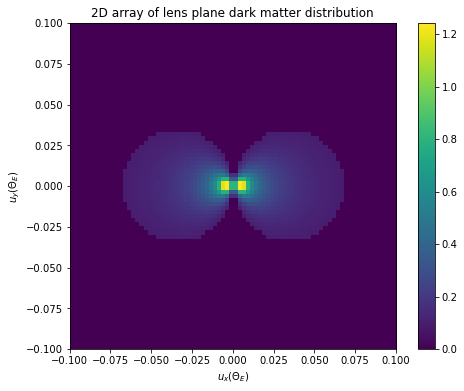

Mass of lens = 1e-14
Maximum value of observable flux 1.2425996242716832


/tmp/ipykernel_33040/2315402993.py:39: UserWarning: No contour levels were found within the data range.
  pylab.contour(new_image, levels=[245], colors='black', origin='image')


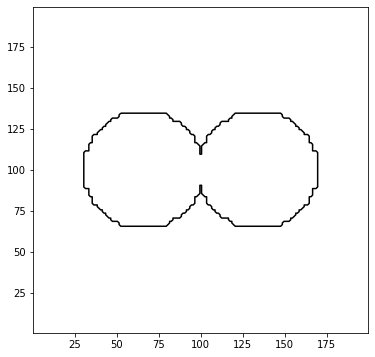

In [162]:
# epsilon, GRB_progenitor_size_factor, num_masses, start_mass, end_mass, Delta_r, DS, x_lens, num_sides, theta
epsilon_tmp = 0.1
GRB_progenitor_size_factor = 0.1
Delta_r = np.array([2*AU/Gpc, L2_point(AU/Gpc,1,M_earth), 2*r_earth/Gpc])
theta = 0

num_masses = 1
start_mass = -5
end_mass = -5

DS_tmp = 4
x_lens = 0.1

num_sides = 80
pixel_length_factor = 0.05

[arr_lens_plane_pos, theta_E, pixel_length_x, pixel_length_y] = sim_lens_plane(epsilon_tmp, GRB_progenitor_size_factor, num_masses, start_mass, end_mass, Delta_r[1], DS_tmp, x_lens, num_sides, theta, pixel_length_factor)

k = 0

# Creates PIL image
#img = Image.fromarray(np.uint8(arr_lens_plane_pos[k] * 255) , 'L')
#img.show()

fig = plt.figure(figsize=(8,6))
pixel_extent = pixel_length_x[k]/(theta_E[k]*DL/num_sides)/2
plt.imshow(arr_lens_plane_pos[k], extent=[-pixel_extent, pixel_extent, -pixel_extent, pixel_extent])
plt.title("2D array of lens plane dark matter distribution")
plt.xlabel('$u_x(\Theta_E)$')
plt.ylabel("$u_y(\Theta_E)$")
plt.colorbar()
plt.show()
print("Mass of lens =",M[k])
print("Maximum value of observable flux",np.max(arr_lens_plane_pos[k]))

image = Image.fromarray(np.uint8(arr_lens_plane_pos[k] * 255), 'L')
new_image = image.resize((int(200*pixel_length_x[k]/pixel_length_y[k]), 200))
fig = plt.figure(figsize=(6,6))
pylab.contour(new_image, levels=[245], colors='black', origin='image')

In [216]:
# Simulating lens plane position of detectable dark matter for single mass and calculating volume

def single_mass_volume(M_input, pixel_length_factor):

    r_S = r_sun
    
    num_masses = 1
    M = np.array([M_input])
    theta_E = np.zeros(num_masses)
    Delta_r = L2_point(AU/Gpc,1,M_earth)

    DS = WMAP9.comoving_distance(2).value/1e3
    chi_S = DS*Gpc
    n_quad = 25
    x_lens = np.arange(1,n_quad)/n_quad

    num_sides = 80
    arr_lens_plane_pos = np.zeros((num_masses,num_sides,num_sides))

    beta1 = 0
    beta2 = 0
    u1 = 0
    u2 = 0

    count = np.zeros(num_masses)
    pixel_length_x = np.zeros(num_masses)
    pixel_length_y = np.zeros(num_masses)

    sigma_lens = np.zeros(np.size(x_lens))
    V_lens = 0

    k=0

    # Calculating Einstein angles for each mass of lens (this can be done within the next loop if the plotting part is removed)
    #theta_E[k] = Einstein_angle(M[k],D)

    # Finding the threshold value of u=u_T for different masses at a given epsilon and theta_E
    #u_T = np.zeros(num_masses)

    #calc_threshold = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u) - 1 - epsilon
    #u_T[k] = newton(calc_threshold, 2)    # u_T is dimensionless

    #calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u)


    for l in range(np.size(x_lens)):

        DL = x_lens[l]*DS
        DLS = DS - DL
        D = DL*DS/DLS
        D = 1
        theta_E[k] = Einstein_angle(M[k],D)
        calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u)

        #print('Iteration:',l)

        pixel_length_x[k] = pixel_length_factor*theta_E[k]*DL/num_sides
        pixel_length_y[k] = pixel_length_factor*theta_E[k]*DL/num_sides

        for j in range(num_sides):

            for i in range(int(num_sides)):

                tmp_x = ((i - num_sides/2) + 0.5)*pixel_length_x[k]
                tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]

                beta1 = np.sqrt((tmp_x - Delta_r/2*(1-x_lens[l]))**2 + tmp_y**2)/(DS)
                beta2 = np.sqrt((tmp_x + Delta_r/2*(1-x_lens[l]))**2 + tmp_y**2)/(DS)

                u1 = beta1/theta_E[k]
                u2 = beta2/theta_E[k]
                
                A1 = calc_finite(u1)
                A2 = calc_finite(u2)

                if A1 > (1 + epsilon) or A2 > (1 + epsilon):
                    if np.abs(A1 - A2)/(A1 + A2) > epsilon / 2:
                        count[k]+=1
                        arr_lens_plane_pos[k,i,j]=np.abs(A1 - A2)/(A1 + A2)

        sigma_lens[l] = (count[k]*pixel_length_x[k]*Gpc*pixel_length_y[k]*Gpc) * chi_S * x_lens[l]**2
        #print("count:",count[k])
        count[k] = 0

    # Midpoint quadrature rule
    h = (np.max(x_lens)-np.min(x_lens))/np.size(x_lens)

    # V_lens = h*(f(a)/2 + f(a+h) + f(a+2h) + ... f(b))
    V_lens = sigma_lens[0]/2 + sigma_lens[np.size(x_lens)-1]/2
    for l in range(1,np.size(x_lens)-1):
        V_lens += sigma_lens[l]
    V_lens *= h
    print("Volume occupied by Lens:",V_lens)

    print('')
    
    return (V_lens)

In [217]:
# Run with DS = 4Gpc

num_masses = 46
start_mass = -14
end_mass = -5
M = np.logspace(start_mass,end_mass,num_masses)
V_lens_wrapper = np.zeros(num_masses)

alpha = np.log(4000)/(end_mass - start_mass)
A = 200/np.exp(-start_mass*alpha)
pixel_length_factor = np.round(A*np.exp(-alpha*np.log10(M)),2)

for l in range(num_masses):
    print('Iteration:',l)
    V_lens_wrapper[l] = single_mass_volume(M[l], pixel_length_factor[l])

print(V_lens_wrapper)

Iteration: 0
Volume occupied by Lens: 0.0

Iteration: 1
Volume occupied by Lens: 0.0

Iteration: 2
Volume occupied by Lens: 0.0

Iteration: 3
Volume occupied by Lens: 0.0

Iteration: 4
Volume occupied by Lens: 0.0

Iteration: 5
Volume occupied by Lens: 0.0

Iteration: 6
Volume occupied by Lens: 0.0

Iteration: 7
Volume occupied by Lens: 1.3230300059511717e+43

Iteration: 8
Volume occupied by Lens: 6.035309751428851e+43

Iteration: 9
Volume occupied by Lens: 1.3154104909766768e+44

Iteration: 10
Volume occupied by Lens: 2.1760741189246174e+44

Iteration: 11
Volume occupied by Lens: 3.0193697454076095e+44

Iteration: 12
Volume occupied by Lens: 4.0545830815159675e+44

Iteration: 13
Volume occupied by Lens: 5.418820619780749e+44

Iteration: 14
Volume occupied by Lens: 6.6090199433410545e+44

Iteration: 15
Volume occupied by Lens: 7.762294365916343e+44

Iteration: 16
Volume occupied by Lens: 9.532832568204475e+44

Iteration: 17
Volume occupied by Lens: 1.0799351796432152e+45

Iteration: 18

In [218]:
np.savetxt("DS4_D1_rS1_M14_M5_e01_numsides80.csv", V_lens_wrapper, delimiter=",")

In [219]:
n = lambda f: rho_crit_0 * Omega_DM * f / M
print(n(1))

[1.19730000e-43 7.55445229e-44 4.76653715e-44 3.00748162e-44
 1.89759262e-44 1.19730000e-44 7.55445229e-45 4.76653715e-45
 3.00748162e-45 1.89759262e-45 1.19730000e-45 7.55445229e-46
 4.76653715e-46 3.00748162e-46 1.89759262e-46 1.19730000e-46
 7.55445229e-47 4.76653715e-47 3.00748162e-47 1.89759262e-47
 1.19730000e-47 7.55445229e-48 4.76653715e-48 3.00748162e-48
 1.89759262e-48 1.19730000e-48 7.55445229e-49 4.76653715e-49
 3.00748162e-49 1.89759262e-49 1.19730000e-49 7.55445229e-50
 4.76653715e-50 3.00748162e-50 1.89759262e-50 1.19730000e-50
 7.55445229e-51 4.76653715e-51 3.00748162e-51 1.89759262e-51
 1.19730000e-51 7.55445229e-52 4.76653715e-52 3.00748162e-52
 1.89759262e-52 1.19730000e-52]


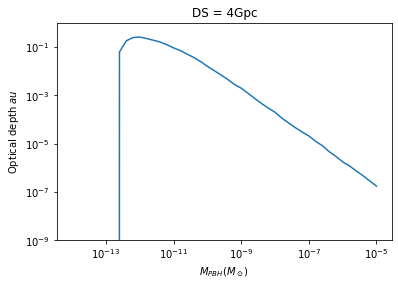

In [220]:
tau = lambda f: n(f) * V_lens_wrapper

# Plot Optical Depth vs Mass of lens
plt.plot(M, tau(1))

plt.title('DS = 4Gpc')
plt.xlabel('$M_{PBH} (M_\odot)$')
plt.xscale('log')
plt.ylabel('Optical depth $\tau$')
plt.yscale('log')
plt.ylim([1e-9,1])

plt.show()

[0.         0.         0.         0.         0.         0.
 0.         0.04771761 0.0167195  0.0121083  0.0115628  0.01327771
 0.01560246 0.01854677 0.02417594 0.03262222 0.04203622 0.05871766
 0.0810791  0.11997177 0.18805041 0.28148124 0.42621588 0.65285211
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


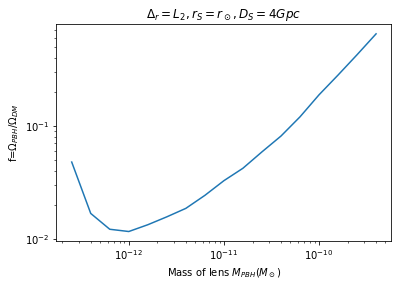

In [224]:
f_final = np.zeros(num_masses)
for k in range(num_masses):
    tau = lambda f: n(f)[k] * V_lens_wrapper[k]
    
    P1 = lambda f: tau(f) * np.exp(-tau(f))
    P_null = lambda f: ((1 - P1(f))**(1000/1000))**1000
    
    num_f = 1000
    f = np.logspace(-5,0,num_f)
    #print(f)
    y_P = np.zeros(num_f)
    y_2 = np.ones(num_f)*0.05
    for i in range(num_f):
        y_P[i] = P_null(f[i])
    for l in range(num_f):
        if y_P[l] < 0.05:
            f_final[k] = f[l]
            break

print(f_final)
# Plot f vs Mass of lens

plt.title('$\Delta_r = L_2, r_S = r_\odot, D_S = 4Gpc$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass of lens $M_{PBH}(M_\odot)$')
plt.ylabel('f=$\Omega_{PBH}/\Omega_{DM}$')
plt.plot(M[7:24],f_final[7:24])